In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder

# ignore information messages from tensorflow, but we will receive error messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

def load_custom_dataset(dataset_path, img_size=(224, 224)):
    """
    Load custom dataset from directory structure

    Args:
        dataset_path: Path to dataset directory containing train/ and test/
        img_size: Tuple of (height, width) to resize images to

    Returns:
        (X_train, Y_train), (X_test, Y_test), label_encoder
    """

    def load_images_from_folder(folder_path):
        images = []
        labels = []

        # Get all class folders
        class_names = sorted([d for d in os.listdir(folder_path)
                            if os.path.isdir(os.path.join(folder_path, d))])

        print(f"Found classes: {class_names}")

        for class_name in class_names:
            class_folder = os.path.join(folder_path, class_name)

            # Get all image files
            image_files = [f for f in os.listdir(class_folder)
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

            print(f"Loading {len(image_files)} images from {class_name}...")

            for img_file in image_files:
                img_path = os.path.join(class_folder, img_file)

                try:
                    # Load and resize image
                    img = Image.open(img_path).convert('RGB')
                    img = img.resize(img_size)
                    img_array = np.array(img)

                    images.append(img_array)
                    labels.append(class_name)

                except Exception as e:
                    print(f"Error loading {img_path}: {e}")

        return np.array(images), np.array(labels)

    # Load train and test data
    train_path = os.path.join(dataset_path, 'train')
    test_path = os.path.join(dataset_path, 'test')

    print("Loading training data...")
    X_train, Y_train_names = load_images_from_folder(train_path)

    print("\nLoading test data...")
    X_test, Y_test_names = load_images_from_folder(test_path)

    # Encode labels to integers
    label_encoder = LabelEncoder()
    label_encoder.fit(np.concatenate([Y_train_names, Y_test_names]))

    Y_train = label_encoder.transform(Y_train_names).reshape(-1, 1)
    Y_test = label_encoder.transform(Y_test_names).reshape(-1, 1)

    print(f"\nClass mapping:")
    for i, class_name in enumerate(label_encoder.classes_):
        print(f"  {i}: {class_name}")

    return (X_train, Y_train), (X_test, Y_test), label_encoder



In [5]:
# Load your custom dataset
dataset_path = '/content/drive/MyDrive/dataset-v2'  # Change this to your dataset path
(X_train, Y_train), (X_test, Y_test), label_encoder = load_custom_dataset(dataset_path, img_size=(224, 224))

print(f"\nDataset loaded successfully!")
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

# Get class names
class_names = label_encoder.classes_
print(f"Classes: {class_names}")


Loading training data...
Found classes: ['avoy', 'navin', 'rakin', 'yousha']
Loading 154 images from avoy...
Loading 145 images from navin...
Loading 156 images from rakin...
Loading 145 images from yousha...

Loading test data...
Found classes: ['avoy', 'navin', 'rakin', 'yousha']
Loading 4 images from avoy...
Loading 5 images from navin...
Loading 4 images from rakin...
Loading 5 images from yousha...

Class mapping:
  0: avoy
  1: navin
  2: rakin
  3: yousha

Dataset loaded successfully!
X_train shape: (600, 224, 224, 3), Y_train shape: (600, 1)
X_test shape: (18, 224, 224, 3), Y_test shape: (18, 1)
Classes: ['avoy' 'navin' 'rakin' 'yousha']


In [6]:
# Create random indices
train_indices = np.random.permutation(len(X_train))

# Shuffle both X_train and Y_train using the same indices
X_train = X_train[train_indices]
Y_train = Y_train[train_indices]

print(f"\nData shuffled successfully!")
print(f"X_train shape after shuffle: {X_train.shape}")
print(f"Y_train shape after shuffle: {Y_train.shape}")

# Create random indices
test_indices = np.random.permutation(len(X_test))

# Shuffle both X_train and Y_train using the same indices
X_test = X_test[test_indices]
Y_test = Y_test[test_indices]

print(f"\nData shuffled successfully!")
print(f"X_test shape after shuffle: {X_test.shape}")
print(f"Y_test shape after shuffle: {Y_test.shape}")



Data shuffled successfully!
X_train shape after shuffle: (600, 224, 224, 3)
Y_train shape after shuffle: (600, 1)

Data shuffled successfully!
X_test shape after shuffle: (18, 224, 224, 3)
Y_test shape after shuffle: (18, 1)


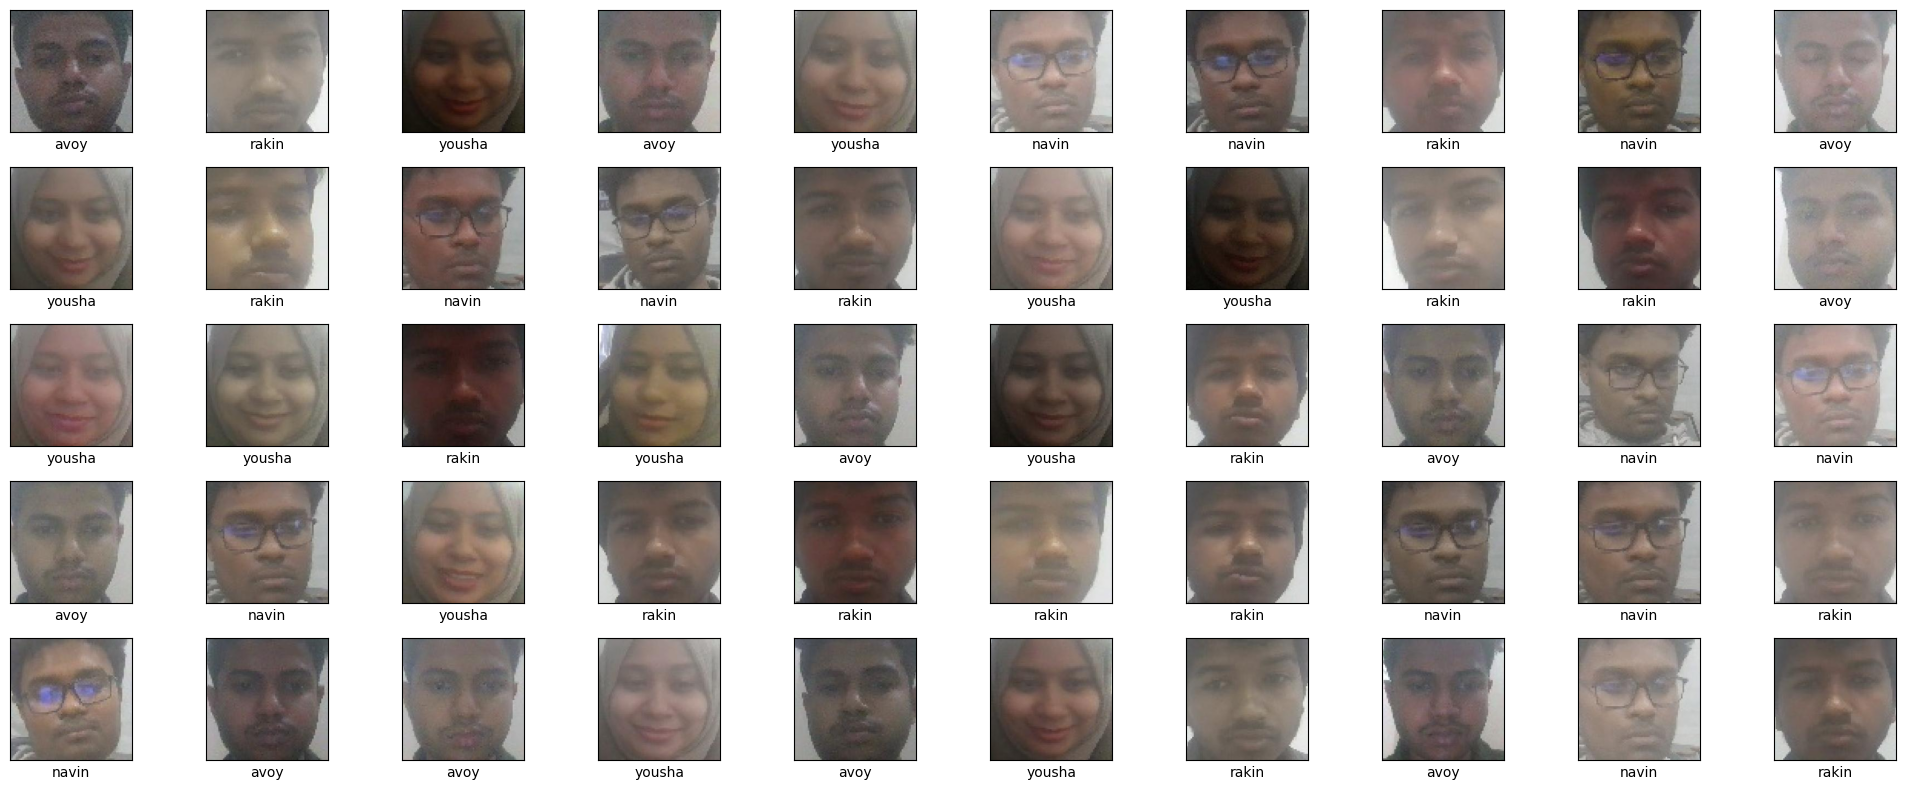

In [7]:
num_samples = min(50, len(X_train))  # Show up to 50 samples
plt.figure(figsize=(20, 8))
for i in range(num_samples):
    plt.subplot(5, 10, i+1)
    plt.imshow(X_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(class_names[Y_train[i][0]])
plt.tight_layout()
plt.show()

In [8]:
X_train, X_test = X_train / 255.0, X_test / 255.0

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [10]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import models, layers
import tensorflow as tf

num_classes = len(class_names)

# Rebuild model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#base_model.trainable = False  # Freeze base model


model = models.Sequential([
    keras.Input(shape=(224, 224, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,146,692 (92.11 MB)

 Trainable params: 24,093,060 (91.91 MB)

 Non-trainable params: 53,632 (209.50 KB)

In [11]:
from tensorflow.keras.optimizers import RMSprop
model.compile(
    optimizer=RMSprop(learning_rate=0.0001),  # Lower learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [12]:
# Now train with aggressive weights
class_weight_dict = {
    0: 2.0,  # avoy
    1: 2.0,  # rakin
    2: 2.0,  # yousha
    3: 0.3   # navin - heavily penalize
}

print("\nAggressive weights:")
for i, class_name in enumerate(class_names):
    print(f"  {class_name}: {class_weight_dict[i]}")



h = model.fit(
    X_train, Y_train,
    validation_split=0.2,
    epochs=30,  # More epochs with early stopping
    batch_size=32,  # Larger batch size
    #class_weight=class_weight_dict,
    #callbacks=callbacks,
    verbose=1
)



Aggressive weights:
  avoy: 2.0
  navin: 2.0
  rakin: 2.0
  yousha: 0.3
Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 61s 847ms/step - accuracy: 0.5966 - loss: 1.2119 - val_accuracy: 0.2500 - val_loss: 1.4152
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 295ms/step - accuracy: 0.9555 - loss: 0.1593 - val_accuracy: 0.2917 - val_loss: 1.4575
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 290ms/step - accuracy: 0.9972 - loss: 0.0518 - val_accuracy: 0.2917 - val_loss: 1.4325
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 292ms/step - accuracy: 1.0000 - loss: 0.0203 - val_accuracy: 0.2500 - val_loss: 1.4007
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 300ms/step - accuracy: 0.9908 - loss: 0.0329 - val_accuracy: 0.2500 - val_loss: 1.4497
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 294ms/step - accuracy: 1.0000 - loss: 0.0106 - val_accuracy: 0.2000 - val_loss: 1.6390
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 296ms/step - accuracy: 1.0000 - loss: 0.0094 - val_accuracy: 0.2500 - val_loss: 1.5905
Epoch 8/30
15/15 ━━━━━━━━━━━━━

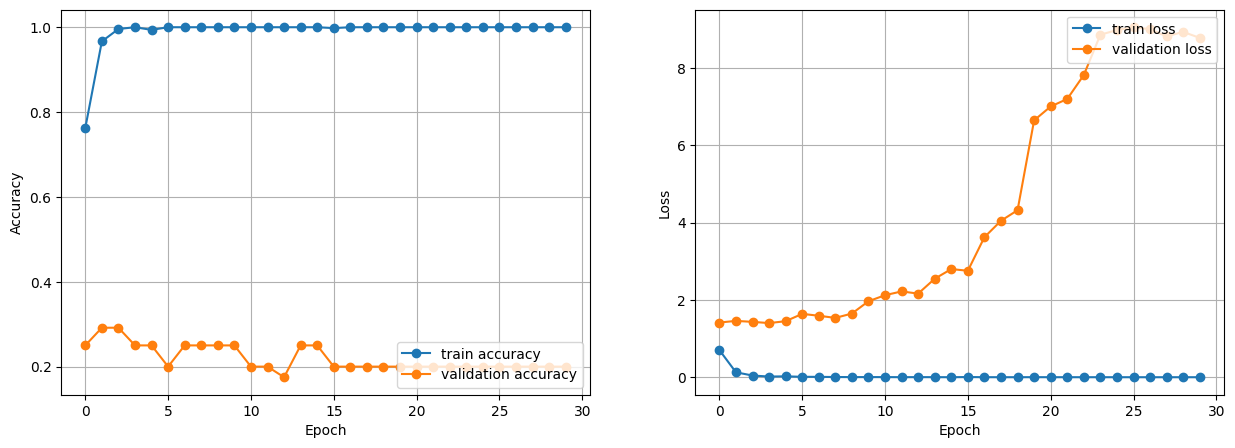

In [13]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], 'o-', label='train accuracy')
plt.plot(h.history['val_accuracy'], 'o-', label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'], 'o-', label='train loss')
plt.plot(h.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

In [14]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.2222 - loss: 8.5229

Test Accuracy: 0.2222222238779068

Test Loss: 8.522899627685547


In [15]:
predictions = model.predict(X_test)

print("\nFirst prediction probabilities:")
print(predictions[0])
print(f"Predicted class: {class_names[np.argmax(predictions[0])]}")
print(f"Actual class: {class_names[Y_test[0][0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

First prediction probabilities:
[3.0529227e-06 2.6523617e-06 9.9994099e-01 5.3287375e-05]
Predicted class: rakin
Actual class: rakin


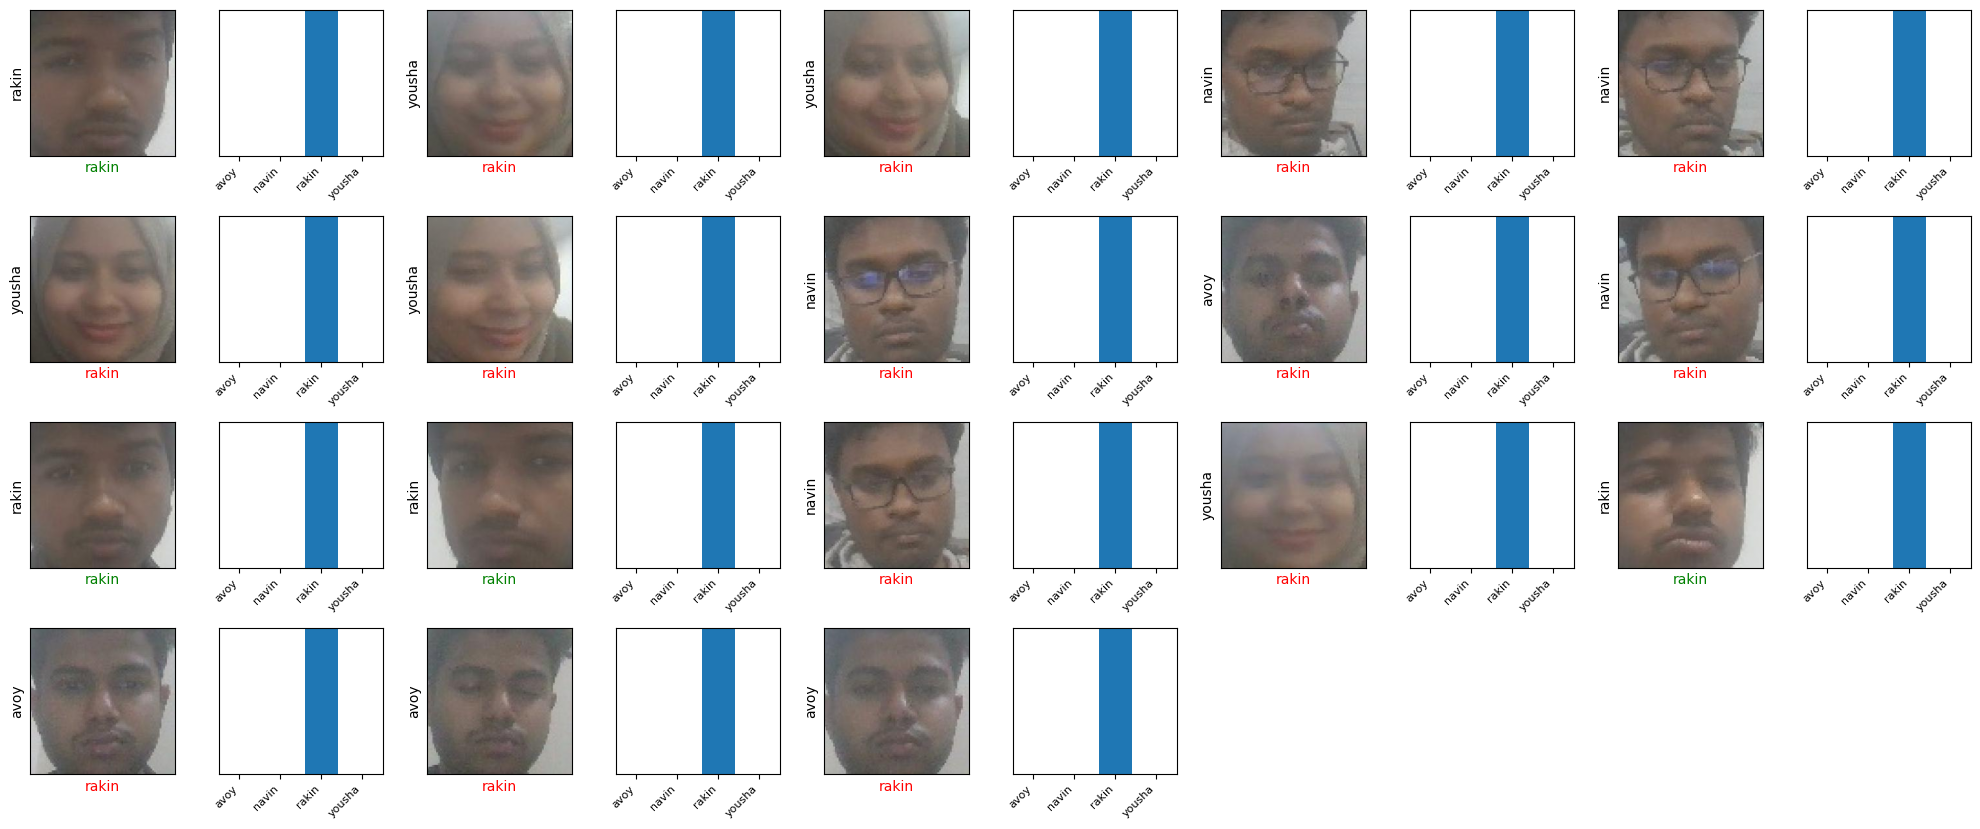

In [16]:
num_predictions = min(25, len(X_test))
rows = 5
cols = 5

plt.figure(figsize=(20, 10))
for i in range(num_predictions):
    # Show image
    plt.subplot(rows, 2*cols, 2*i+1)
    plt.imshow(X_test[i])
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(class_names[Y_test[i][0]])

    # Color code predictions: green if correct, red if incorrect
    if Y_test[i][0] == np.argmax(predictions[i]):
        plt.xlabel(class_names[np.argmax(predictions[i])], color='g')
    else:
        plt.xlabel(class_names[np.argmax(predictions[i])], color='r')

    # Show prediction bar chart
    plt.subplot(rows, 2*cols, 2*i+2)
    plt.bar(range(num_classes), predictions[i])
    plt.yticks([])
    plt.xticks(range(num_classes), class_names, rotation=45, ha='right', fontsize=8)
    plt.ylim([0, 1])
    plt.xlim([-0.5, num_classes-0.5])

plt.tight_layout()
plt.show()

In [17]:
# Save the trained model
model_path = 'face_recognition_model.h5'
model.save(model_path)
print(f"\nModel saved successfully to: {model_path}")

# Save the label encoder for later use
import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("Label encoder saved to: label_encoder.pkl")



Model saved successfully to: face_recognition_model.h5
Label encoder saved to: label_encoder.pkl
